In [3]:
# import libraries
import MDAnalysis as mda
import pandas as pd
print(mda.__version__)

1.0.0


In [4]:
# define universe
u = mda.Universe("md_0_1.gro", "md_0_1.xtc")
print(u)
print(len(u.trajectory))
print("Number of residues: ", print(u.residues))
print("Number of atoms:", print(u.atoms))

<Universe with 31322 atoms>
1001
<ResidueGroup [<Residue VAL, 2>, <Residue ASN, 3>, <Residue PRO, 4>, ..., <Residue SOL, 9776>, <Residue CL, 9777>, <Residue CL, 9778>]>
Number of residues:  None
<AtomGroup [<Atom 1: N of type N of resname VAL, resid 2 and segid SYSTEM>, <Atom 2: H1 of type H of resname VAL, resid 2 and segid SYSTEM>, <Atom 3: H2 of type H of resname VAL, resid 2 and segid SYSTEM>, ..., <Atom 31320: HW2 of type H of resname SOL, resid 9776 and segid SYSTEM>, <Atom 31321: CL of type CL of resname CL, resid 9777 and segid SYSTEM>, <Atom 31322: CL of type CL of resname CL, resid 9778 and segid SYSTEM>]>
Number of atoms: None


In [9]:
# select a few atomgroups for analysis
bb = u.select_atoms('protein and backbone')  # a selection (AtomGroup)
#sc = u.select_atoms('protein and sidechain')

In [ ]:
# select special residues
# active site residues:
# most dynamic residues:
# mutation-sensitive residues / preserved:
# residues nearby (w/in x angstroms of) a particular atom or residue:

# select special atoms

# select special non-protein atoms
# hydration sphere: 

In [ ]:
# plot number of internal h-bonds over time:

In [10]:
# radius of gyration
frame = u.trajectory.frame
time = u.trajectory.time
rgyr = u.atoms.radius_of_gyration()
print("Frame: {:3d}, Time: {:4.0f} ps, Rgyr: {:.4f} A".format(frame, time, rgyr))

rgyr = []
time = []
protein = u.select_atoms("protein")
for ts in u.trajectory:
    time.append(u.trajectory.time)
    rgyr.append(protein.radius_of_gyration())

Frame:   0, Time:    0 ps, Rgyr: 33.7043 A


In [12]:
# atoms surrounding a specific residue within x angstroms
dynamic = u.select_atoms('around 2 resname ALA', updating=True)
print(type(dynamic))
dynamic

static = u.select_atoms('around 2 resname ALA')
print(type(static))
static

<class 'MDAnalysis.core.groups.UpdatingAtomGroup'>
<class 'MDAnalysis.core.groups.AtomGroup'>


<AtomGroup with 31 atoms>

In [14]:
# write out specific atoms to a trajectory file
# calpha atoms
ca = u.select_atoms('name CA')
with mda.Writer('calphas.xtc', ca.n_atoms) as w:
    for ts in u.trajectory:
        w.write(ca)

# cbeta atoms; first sidechain atom (if carbon!)
cb = u.select_atoms('name CB')
with mda.Writer('cbetas.xtc', cb.n_atoms) as w:
    for ts in u.trajectory:
        w.write(ca)

# 

# 

In [18]:
# rmsd for whole trajectory
from MDAnalysis.analysis import rms, align

u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()

No handles with labels found to put in legend.


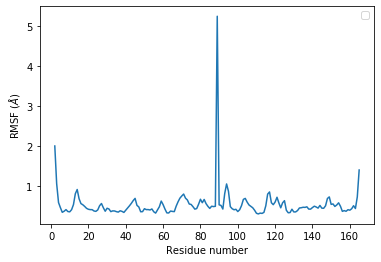

In [20]:
# plot of RMSF!

average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
ref = average.universe
aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()
c_alphas = u.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas).run()

import matplotlib.pyplot as plt

plt.plot(c_alphas.resids, R.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
#plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
#plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend();

In [22]:
# plot onto prot
import nglview as nv

u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
protein = u.select_atoms('protein') # select protein atoms
for residue, r_value in zip(protein.residues, R.rmsf):
    residue.atoms.tempfactors = r_value

view = nv.show_mdanalysis(u)
view.update_representation(color_scheme='bfactor')
view

NGLWidget(max_frame=1000)

In [24]:
# distances b/w specific atoms
from MDAnalysis.analysis import distances

# make pairwise comparisons
# residues: Arg55, His 126, Phe113

#distances.between()

#select arginines???
args = u.select_atoms('resname ARG')
hiss = u.select_atoms('resname HIS')
phes = u.select_atoms('resname PHE')

print("There are this many atoms: "+str(len(args))+" in arginines, "+str(len(hiss))+" in histidines, and "+str(len(phes))+" in phenylalanines.")

dist_arr = distances.distance_array(args.positions, # reference
                                    hiss.positions, # configuration
                                    box=u.dimensions)
dist_arr.shape

There are this many atoms: 144 in arginines, 69 in histidines, and 300 in phenylalanines.


(144, 69)

Text(0, 0.5, 'Distance (Angstrom)')

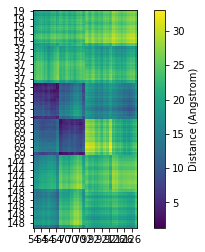

In [31]:
import matplotlib as plt
import numpy as np

fig, ax = plt.pyplot.subplots()
im = ax.imshow(dist_arr, origin='upper')

# add residue ID labels to axes
tick_interval = 5
ax.set_yticks(np.arange(len(args))[::tick_interval])
ax.set_xticks(np.arange(len(hiss))[::tick_interval])
ax.set_yticklabels(args.resids[::tick_interval])
ax.set_xticklabels(hiss.resids[::tick_interval])

# add figure labels and titles
#plt.ylabel('LID')
#plt.xlabel('NMP')
#plt.title('Distance between alpha-carbon')

# colorbar
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Distance (Angstrom)')

Contacts

In [5]:
from MDAnalysis.analysis import contacts

sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

ca1 = contacts.Contacts(u,
                        select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='hard_cut').run()

ca1_df = pd.DataFrame(ca1.timeseries,
                      columns=['Frame',
                               'Contacts from first frame'])
ca1_df.head()


,Frame,Contacts from first frame
0,0.0,1.0000
1,1.0,0.6250
2,2.0,0.3750
3,3.0,0.4375
4,4.0,0.3750


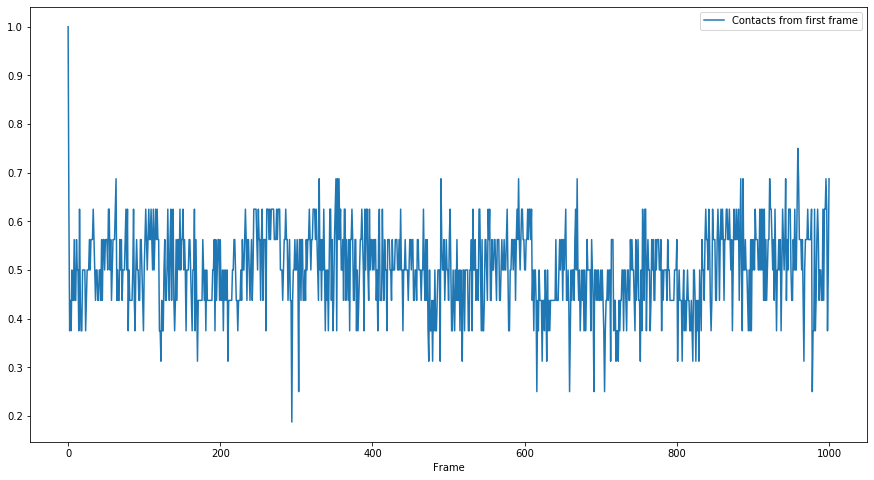

In [17]:
ca1_df.plot(x='Frame', figsize=(15,8))